In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
from pathlib import Path  
import numpy as np
import torch
import cv2
from PIL import Image
import random
project_root = Path.cwd().parent  
# sys.path.append(str(project_root))
os.chdir(project_root)
from src.demo.model import FreeFinePipeline
from src.utils.attention import register_attention_control,Attention_Modulator,register_attention_control_4bggen
from src.utils.vis_utils import temp_view,temp_view_img,load_json,get_constrain_areas,prepare_mask_pool,re_edit_2d,dilate_mask,read_and_resize_mask,re_edit_3d,read_and_resize_img
from diffusers import DDIMScheduler

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
pretrained_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-v1-5/" #Replace with your own ckpt path
model = FreeFinePipeline.from_pretrained(pretrained_model_path, torch_dtype=torch.float16).to(device)
model.scheduler = DDIMScheduler.from_config(model.scheduler.config,)
controller = Attention_Modulator()
model.controller = controller
register_attention_control_4bggen(model, controller)
model.modify_unet_forward()
model.enable_attention_slicing()
model.enable_xformers_memory_efficient_attention()

/home/hszhu/anaconda3/envs/Reggio2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-22 23:27:38.983513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 23:27:38.996052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 23:27:38.999845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 23:27:39.010481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow 

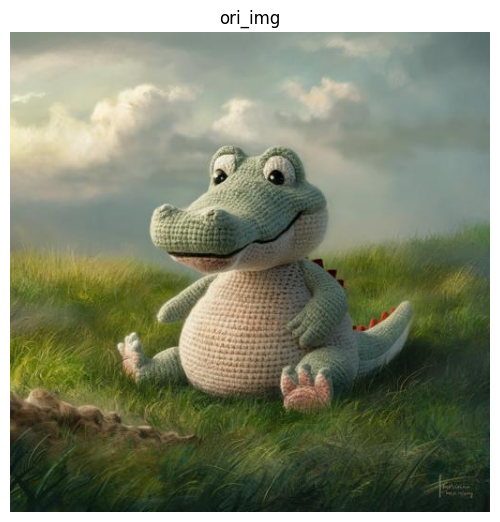

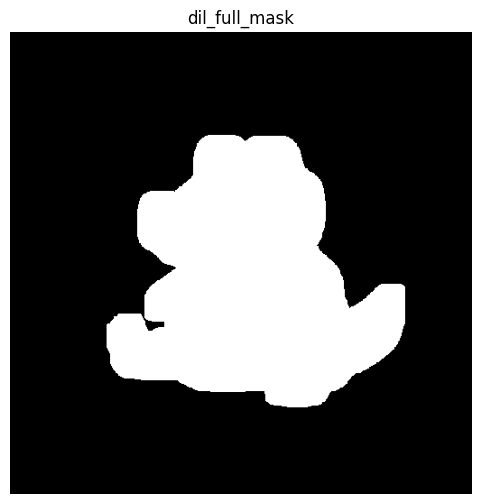

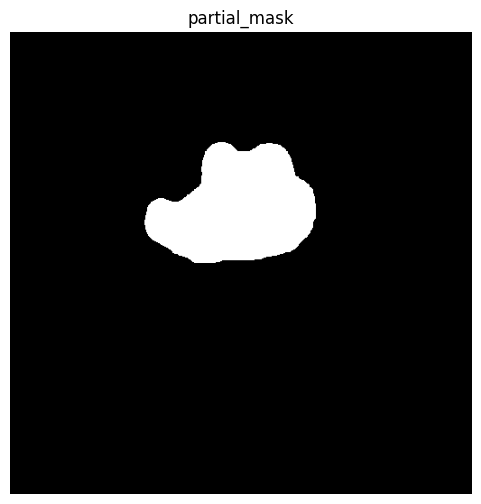

In [2]:
"""
Case selection 
"""
choice_dict = {
    '0':['Examples/Partial-Editing/crocodile/ori.jpg','Examples/Partial-Editing/crocodile/full_mask.png','Examples/Partial-Editing/crocodile/partial_mask.png',None,None,[0,0,15,0.8,0.8],'crocodile'],
    '1':['Examples/Partial-Editing/girl/ori.jpg','Examples/Partial-Editing/girl/full_mask.png','Examples/Partial-Editing/girl/partial_mask.png'],
    '2':['Examples/Partial-Editing/dog/ori.jpg','Examples/Partial-Editing/dog/full_mask.png','Examples/Partial-Editing/dog/partial_mask.png'],
    '3':['Examples/Partial-Editing/man/ori.jpg','Examples/Partial-Editing/man/full_mask.png','Examples/Partial-Editing/man/partial_mask.png'],
    '4':['Examples/Partial-Editing/cat/ori.jpg','Examples/Partial-Editing/cat/full_mask.png','Examples/Partial-Editing/cat/partial_mask_1.png'],
    '5':['Examples/Partial-Editing/cat/ori.jpg','Examples/Partial-Editing/cat/full_mask.png','Examples/Partial-Editing/cat/partial_mask_2.png'],
    '6':['Examples/Partial-Editing/elephant/ori.jpg','Examples/Partial-Editing/elephant/full_mask.png','Examples/Partial-Editing/elephant/partial_mask_1.png'],
}
sample_id = '0'
# sample_id = random.choice(list(choice_dict.keys()))
ori_img_path,ori_mask_path,partial_mask_path,coarse_path_3d,coarse_3d_mask,edit_param,prompt = choice_dict[sample_id]
ori_img = read_and_resize_img(ori_img_path)
ori_mask = read_and_resize_mask(ori_mask_path)
partial_mask = read_and_resize_mask(partial_mask_path)
type='2D'
if coarse_path_3d is not None:
    type = '3D'
    ori_img_3d = read_and_resize_img(coarse_path_3d)
    ori_mask_3d = read_and_resize_mask(coarse_3d_mask)
mask_pool = [ori_mask] #add more object mask if you have, to avoid inpainting on them
constrain_areas = get_constrain_areas(mask_list=mask_pool,ori_mask=ori_mask)
dilation_factor = 20
dil_ori_mask = dilate_mask(ori_mask, dilation_factor)
dil_ori_mask = np.where(constrain_areas,0,dil_ori_mask)
Image.fromarray(dil_ori_mask).save('obj_remove_mask.png')
temp_view_img(ori_img,'ori_img')
temp_view(dil_ori_mask,'dil_full_mask')
temp_view(partial_mask,'partial_mask')

/home/hszhu/anaconda3/envs/Reggio2/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: 840821975559145 is not in bounds, numpy accepts from 0 to 4294967295
  warnings.warn(*args, **kwargs)
Global seed set to 115045890
DDIM Sampler: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


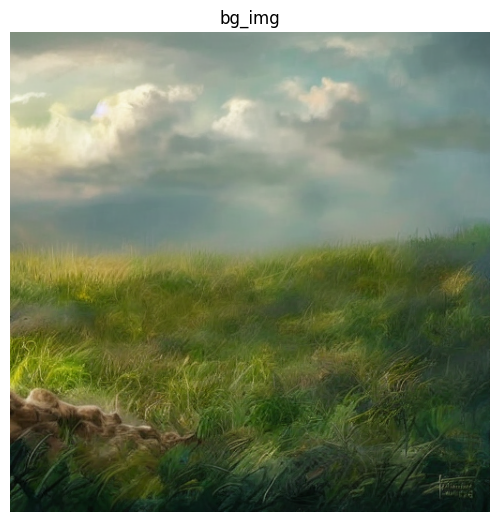

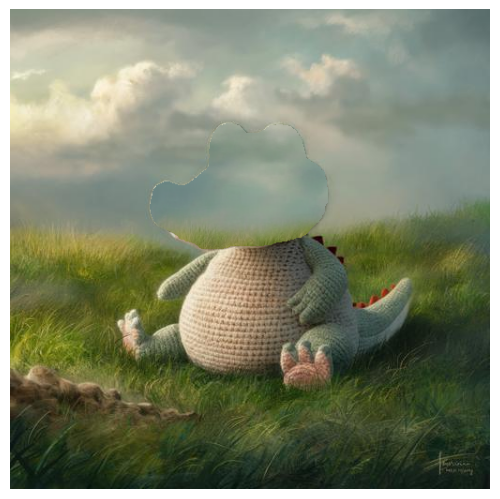

In [3]:
"""
Step1:Background Generation
"""
seed_r = random.randint(0, 10 ** 16)
# seed_r = 42
generated_results = model.FreeFine_background_generation(ori_img, dil_ori_mask, 'empty scene',
                                                         guidance_scale=3.5,eta=1.0, end_step=50,
                                                         num_step=50, end_scale=0.5,
                                                         start_step=1, share_attn=True, method_type='tca',
                                                         local_text_edit=True,
                                                         local_perturbation=True, verbose=True,
                                                         seed=seed_r,
                                                         return_intermediates=False,latent_blended=False,
                                                         )  
temp_view_img(generated_results,'bg_img')
save_img = Image.fromarray(generated_results)
save_img.save("bg_img.png")
inp_back_ground = generated_results
blended = True
if blended:
    #implement fom Brushnet
    mask_blurred = cv2.GaussianBlur(partial_mask, (1, 1), 0) / 255
    mask_np = 1 - (1 - partial_mask) * (1 - mask_blurred)
    image_pasted = ori_img * (1 - mask_np) + generated_results * mask_np
    image_pasted = image_pasted.astype(generated_results.dtype)
    temp_view_img(image_pasted)
    inp_back_ground = image_pasted


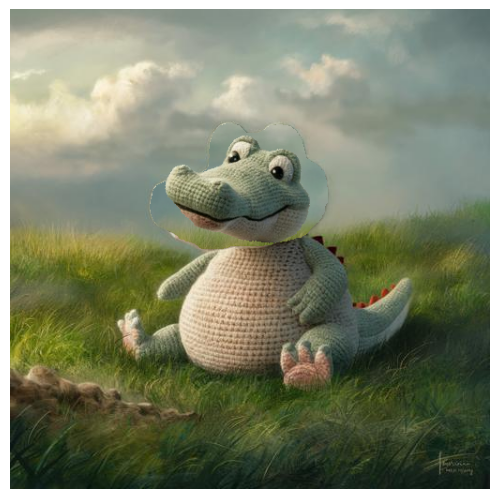

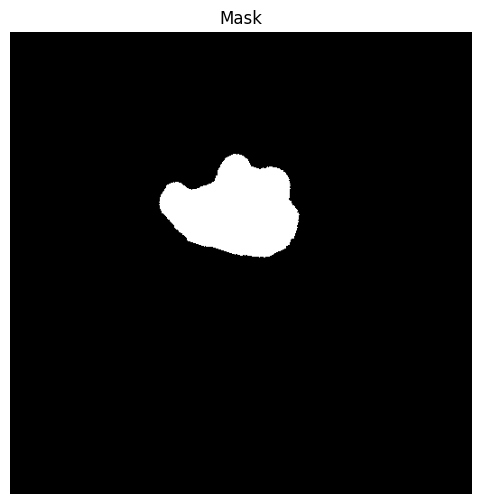

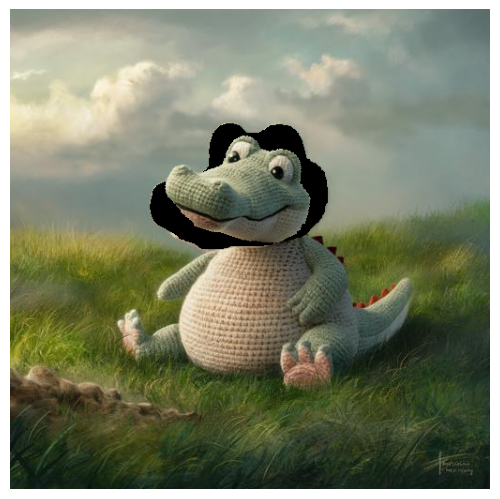

In [4]:
"""
For 2D/3D coarse editing 
"""    
edit_param = edit_param ##feel free to edit with your own param!
edit_param = [0,0,15,0.8,0.8] #dx dy rz sx,sy
if type=='2D':
    coarse_input, target_mask, trans_hole_image = re_edit_2d(ori_img, partial_mask, edit_param, inp_back_ground)
elif type=='3D':
    coarse_input, target_mask, trans_hole_image = re_edit_3d(ori_img_3d, ori_mask_3d, edit_param, inp_back_ground,ori_img, ori_mask)
# temp_view_img(ori_img_3d)
temp_view_img(coarse_input) 
temp_view(target_mask)
temp_view_img(trans_hole_image)
# save_img = Image.fromarray(target_mask)
# save_img.save("tgt_mask.png")


Global seed set to 564988249


current type is tca


DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s] 


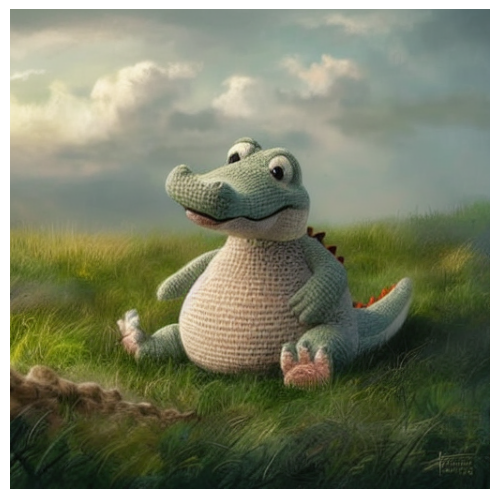

In [29]:
controller = Attention_Modulator(start_layer=10)
model.controller = controller
register_attention_control(model, controller)
model.modify_unet_forward()
model.enable_attention_slicing()
model.enable_xformers_memory_efficient_attention()
seed_r = random.randint(0, 10 ** 16)

generated_results = model.FreeFine_generation(ori_img, partial_mask, coarse_input,
                                              target_mask,
                                                   prompt, guidance_scale=4.0,
                                              eta=1.0, end_scale=0.0,
                                              end_step=50, num_step=50,
                                              start_step=25, share_attn=True, method_type='tca',
                                              local_text_edit=True,
                                              local_perturbation=True, verbose=True,
                                              return_ori=False, seed=seed_r, draw_mask=None,
                                              return_intermediates=False,
                                              use_auto_draw=True,
                                              reduce_inp_artifacts=True,
                                              cons_area=ori_mask-partial_mask,
                                              )  # add gen_res in input_pack
temp_view_img(generated_results)
save_img = Image.fromarray(generated_results)
save_img.save("/data/Hszhu/dataset/temp/generated_results.png")
#adjust the start step to get the best result , the earlier the generation ability will be stronger